## Citi Bike NYC 2018

# Data Preparation

In [162]:
import os
import pandas as pd
from typing import Optional

pd.set_option('display.max_columns', None)

DATA_DIR = os.path.abspath('data')
RAW_TRIPS_PATH = os.path.join(DATA_DIR, 'Trips_2018.csv')
HOLIDAYS_PATH = os.path.join(DATA_DIR, 'holidays_2018_nyc.csv')
EVENTS_PATH = os.path.join(DATA_DIR, 'events_2018_nyc.csv')

RAW_TRIPS_PATH, HOLIDAYS_PATH, EVENTS_PATH


('/Users/estebanperez/Documents/progra/my-py-notebooks/project/data/Trips_2018.csv',
 '/Users/estebanperez/Documents/progra/my-py-notebooks/project/data/holidays_2018_nyc.csv',
 '/Users/estebanperez/Documents/progra/my-py-notebooks/project/data/events_2018_nyc.csv')

In [163]:
# Load holidays and events
holidays = pd.read_csv(HOLIDAYS_PATH, parse_dates=['date'])
# Normalize date to date only
holidays['date'] = holidays['date'].dt.normalize()

events = pd.read_csv(EVENTS_PATH, parse_dates=['start_datetime', 'end_datetime'])

print('Holidays:', holidays.shape)
print('Events:', events.shape)
holidays.head(2)


Holidays: (10, 5)
Events: (13, 6)


,name,date,region,category,notes
0,New Year's Day,2018-01-01,NYC,US Federal,NaN
1,Martin Luther King Jr. Day,2018-01-15,NYC,US Federal,NaN


In [164]:
events.head(2)

,name,start_datetime,end_datetime,borough,category,notes
0,St. Patrick's Day Parade,2018-03-17 11:00:00,2018-03-17 17:00:00,Manhattan,Parade,Fifth Ave corridor closures
1,TD Five Boro Bike Tour,2018-05-06 07:00:00,2018-05-06 17:00:00,Multiple,Sports,Citywide route impacts


### Load raw rides (chunked) and validate schema
We will stream the large CSV to avoid memory pressure. The loader:
- Infers likely Citi Bike column names and standardizes to a canonical schema
- Parses datetimes safely
- drops invalid rows and outliers
- Tracks basic QA metrics (missing rates, outlier rates)



In [165]:
CANONICAL_COLS = {
    "id": "id",
    "tripduration": "trip_duration_sec",
    "starttime": "start_time",
    "stoptime": "end_time",
    "start_station_id": "start_station_id",
    "start_station_latitude": "start_lat",
    "start_station_longitude": "start_lng",
    "end_station_id": "end_station_id",
    "end_station_latitude": "end_lat",
    "end_station_longitude": "end_lng",
    "bikeid": "bike_id",
    "usertype": "user_type",
    "birth_year": "birth_year",
    "gender": "gender",
}

CANONICAL_SET = set(CANONICAL_COLS.values())

DTYPES_BASE = {
    "trip_duration_sec": "float64",
    "start_station_id": "int",
    "end_station_id": "int",
    "bike_id": "string",
    "user_type": "string",
    "birth_year": "float64",
    "gender": "string",
    "start_lat": "float64",
    "start_lng": "float64",
    "end_lat": "float64",
    "end_lng": "float64",
}

CHUNKSIZE = 250_000


def _standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    mapping = {}
    for col in df.columns:
        low = col.strip().lower()
        mapping[col] = CANONICAL_COLS[low]

    df = df.rename(columns=mapping)
    return df


def _parse_times(df: pd.DataFrame) -> pd.DataFrame:
    df["start_time"] = pd.to_datetime(df["start_time"], errors="coerce")
    df["end_time"] = pd.to_datetime(df["end_time"], errors="coerce")
    return df


def _compute_duration_if_missing(df: pd.DataFrame) -> pd.DataFrame:
    if "trip_duration_sec" not in df.columns:
        df["trip_duration_sec"] = (df["end_time"] - df["start_time"]).dt.total_seconds()
    return df


def _filter_invalid(df: pd.DataFrame) -> pd.DataFrame:
    # Drop invalid times
    if {"start_time", "end_time"}.issubset(df.columns):
        df = df[df["start_time"].notna() & df["end_time"].notna()]
        df = df[df["end_time"] >= df["start_time"]]
    # Duration sanity: 1 minute to 24 hours
    if "trip_duration_sec" in df.columns:
        df = df[
            (df["trip_duration_sec"] >= 60) & (df["trip_duration_sec"] <= 24 * 3600)
        ]
    return df


def _cast_types(df: pd.DataFrame) -> pd.DataFrame:
    for col, dtype in DTYPES_BASE.items():
        if col in df.columns:
            df[col] = df[col].astype(dtype, errors="ignore")
    return df


def _filter_geographic_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove trips with stations outside NYC geographic boundaries.

    NYC approximate bounding box:
    - Latitude: 40.4774 to 40.9176 (Bronx to Staten Island)
    - Longitude: -74.2591 to -73.7004 (Staten Island to Queens)

    This filters out erroneous GPS coordinates and stations in other cities
    (e.g., Montreal stations that appeared in the dataset).
    """
    # NYC bounding box (with small buffer for edge stations)
    NYC_LAT_MIN = 40.47
    NYC_LAT_MAX = 40.92
    NYC_LNG_MIN = -74.26
    NYC_LNG_MAX = -73.70

    initial_len = len(df)

    # Filter start station coordinates
    if {"start_lat", "start_lng"}.issubset(df.columns):
        df = df[
            (df["start_lat"] >= NYC_LAT_MIN)
            & (df["start_lat"] <= NYC_LAT_MAX)
            & (df["start_lng"] >= NYC_LNG_MIN)
            & (df["start_lng"] <= NYC_LNG_MAX)
        ]

    # Filter end station coordinates
    if {"end_lat", "end_lng"}.issubset(df.columns):
        df = df[
            (df["end_lat"] >= NYC_LAT_MIN)
            & (df["end_lat"] <= NYC_LAT_MAX)
            & (df["end_lng"] >= NYC_LNG_MIN)
            & (df["end_lng"] <= NYC_LNG_MAX)
        ]

    removed = initial_len - len(df)
    if removed > 0:
        print(f"   ⚠️  Removed {removed} trips with stations outside NYC boundaries")

    return df


def load_trips_stream(path: str, limit_chunks: Optional[int] = None) -> pd.DataFrame:
    qa_stats = []
    chunks = []
    for i, chunk in enumerate(pd.read_csv(path, chunksize=CHUNKSIZE, low_memory=True)):
        c0 = len(chunk)
        chunk = _standardize_columns(chunk)
        chunk = _parse_times(chunk)
        chunk = _compute_duration_if_missing(chunk)
        chunk = chunk.dropna()
        chunk = _filter_geographic_outliers(chunk)
        # keep only canonical columns if present
        cols_to_keep = [
            c
            for c in chunk.columns
            if c in CANONICAL_SET or c in {"start_time", "end_time"}
        ]
        chunk = chunk[cols_to_keep]
        chunk = _filter_invalid(chunk)
        chunk = _cast_types(chunk)
        c1 = len(chunk)
        qa_stats.append(
            {
                "chunk": i,
                "rows_dropped": c0 - c1,
                "drop_rate": (c0 - c1) / max(1, c0),
            }
        )
        chunks.append(chunk)
        if limit_chunks is not None and i + 1 >= limit_chunks:
            break
    trips = pd.concat(chunks, ignore_index=True)
    qa = pd.DataFrame(qa_stats)
    print("QA summary:")
    display(qa.describe(include="all"))
    print(f"Total dropped: {qa['rows_dropped'].sum()}")
    return trips


# Preview small sample for speed; set limit_chunks=None to process all
trips_sample = load_trips_stream(RAW_TRIPS_PATH, limit_chunks=None)
trips_sample.head()

   ⚠️  Removed 36 trips with stations outside NYC boundaries
   ⚠️  Removed 11 trips with stations outside NYC boundaries
   ⚠️  Removed 9 trips with stations outside NYC boundaries
   ⚠️  Removed 1 trips with stations outside NYC boundaries
   ⚠️  Removed 10 trips with stations outside NYC boundaries
   ⚠️  Removed 1 trips with stations outside NYC boundaries
   ⚠️  Removed 12 trips with stations outside NYC boundaries
   ⚠️  Removed 1 trips with stations outside NYC boundaries
   ⚠️  Removed 1 trips with stations outside NYC boundaries
QA summary:


,chunk,rows_dropped,drop_rate
count,71.000000,71.000000,71.000000
mean,35.000000,99.830986,0.000407
std,20.639767,85.367104,0.000341
min,0.000000,25.000000,0.000100
25%,17.500000,52.000000,0.000212
50%,35.000000,71.000000,0.000292
75%,52.500000,110.500000,0.000460
max,70.000000,517.000000,0.002068


Total dropped: 7088


,id,trip_duration_sec,start_time,end_time,start_station_id,start_lat,start_lng,end_station_id,end_lat,end_lng,bike_id,user_type,birth_year,gender
0,0,970.0,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72,40.767272,-73.993929,505,40.749013,-73.988484,31956,Subscriber,1992.0,1
1,1,723.0,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72,40.767272,-73.993929,3255,40.750585,-73.994685,32536,Subscriber,1969.0,1
2,2,496.0,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72,40.767272,-73.993929,525,40.755942,-74.002116,16069,Subscriber,1956.0,1
3,3,306.0,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72,40.767272,-73.993929,447,40.763707,-73.985162,31781,Subscriber,1974.0,1
4,4,306.0,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72,40.767272,-73.993929,3356,40.774667,-73.984706,30319,Subscriber,1992.0,1


In [166]:
trips_sample.shape

(17541251, 14)

In [167]:
trips_sample.isnull().sum()

id                   0
trip_duration_sec    0
start_time           0
end_time             0
start_station_id     0
start_lat            0
start_lng            0
end_station_id       0
end_lat              0
end_lng              0
bike_id              0
user_type            0
birth_year           0
gender               0
dtype: int64

## Station data and activity metrics

Now that we have a clean trip dataset, we need to create a station-level view of the system. 

For each unique station, we will:
1. Extract station metadata: ID, latitude, longitude
2. Aggregate demand metrics:
   - Pickups: Number of trips that started at this station
   - Dropoffs: Number of trips that ended at this station
   - Total activity: Sum of pickups and dropoffs

This station-centric dataset will enable:
- Spatial clustering (grouping nearby stations)
- Demand pattern analysis (identifying high/low activity stations)

This aggregation transforms 17.5M trip records into 846 station profiles that will help in the futire for clustering and forecasting.

In [168]:
# Extract start station metadata
start_stations = trips_sample[['start_station_id', 'start_lat', 'start_lng']].copy()
start_stations.columns = ['station_id', 'lat', 'lng']

# Extract end station metadata
end_stations = trips_sample[['end_station_id', 'end_lat', 'end_lng']].copy()
end_stations.columns = ['station_id', 'lat', 'lng']

# Combine and remove duplicates
stations = pd.concat([start_stations, end_stations], ignore_index=True)
stations = stations.drop_duplicates(subset='station_id').reset_index(drop=True)

print(f"Total unique stations: {len(stations)}")
stations.head()

Total unique stations: 844


,station_id,lat,lng
0,72,40.767272,-73.993929
1,79,40.719116,-74.006667
2,82,40.711174,-74.000165
3,83,40.683826,-73.976323
4,119,40.696089,-73.978034


In [169]:
# Count how many trips start/end in each station
start_counts = trips_sample.groupby('start_station_id').size().rename('pickup_count')
end_counts = trips_sample.groupby('end_station_id').size().rename('dropoff_count')
display(start_counts.head())
display(end_counts.head())  

start_station_id
72     38403
79     27194
82     10217
83     13115
119     3235
Name: pickup_count, dtype: int64

end_station_id
72     38580
79     27557
82     10451
83     13813
119     3796
Name: dropoff_count, dtype: int64

In [170]:
# Merge with station metadata
stations = stations.merge(start_counts, left_on='station_id', right_index=True, how='left')
stations = stations.merge(end_counts, left_on='station_id', right_index=True, how='left')

# Fill NaN with 0 (stations without trips)
stations[['pickup_count', 'dropoff_count']] = stations[['pickup_count', 'dropoff_count']].fillna(0).astype(int)

# Calculate total activity
stations['total_trips'] = stations['pickup_count'] + stations['dropoff_count']

# Sort by activity
stations = stations.sort_values('total_trips', ascending=False).reset_index(drop=True)

print(f"Total unique stations: {len(stations)}")
stations.head(10)

Total unique stations: 844


,station_id,lat,lng,pickup_count,dropoff_count,total_trips
0,519,40.751873,-73.977706,150246,149925,300171
1,497,40.737050,-73.990093,108865,113323,222188
2,435,40.741740,-73.994156,107154,108634,215788
3,402,40.740343,-73.989551,105592,109143,214735
4,426,40.717548,-74.013221,94453,99422,193875
5,285,40.734546,-73.990741,93353,93579,186932
6,477,40.756405,-73.990026,87941,88136,176077
7,490,40.751551,-73.993934,85287,85276,170563
8,499,40.769155,-73.981918,84950,83358,168308
9,514,40.760875,-74.002777,82316,85136,167452


## Visualization (geographic distribution) of bike stations


Below is an interactive map showing all 846 Citi Bike stations in NYC. Each marker represents a station, with:
- **Color intensity**: Indicates total trip volume (darker = higher activity)
- **Popup info**: Station ID, coordinates, and trip counts (pickups/dropoffs)

This visualization helps identify:
- High-demand areas (Manhattan Midtown, Financial District)
- Geographic coverage and density patterns
- Potential clusters for spatial aggregation

In [171]:
# dependencies we will use
import folium
from folium.plugins import MarkerCluster
import numpy as np

In [172]:
# Create base map centered on NYC
nyc_center = [stations["lat"].mean(), stations["lng"].mean()]
m = folium.Map(location=nyc_center, zoom_start=12, tiles="CartoDB Positron")

# NYC bounding box
NYC_LAT_MIN = 40.47
NYC_LAT_MAX = 40.92
NYC_LNG_MIN = -74.26
NYC_LNG_MAX = -73.70
folium.Rectangle(
    bounds=[[NYC_LAT_MIN, NYC_LNG_MIN], [NYC_LAT_MAX, NYC_LNG_MAX]],
    color="blue",
    fill=False,
    weight=3,
    opacity=0.8,
    popup="NYC Bounding Box",
).add_to(m)

# Normalize total_trips for color scaling
min_trips = stations["total_trips"].min()
max_trips = stations["total_trips"].max()

# Add markers for each station
for idx, row in stations.iterrows():
    normalized = (row["total_trips"] - min_trips) / (max_trips - min_trips)

    if normalized > 0.7:
        color = "red"
    elif normalized > 0.4:
        color = "orange"
    elif normalized > 0.2:
        color = "yellow"
    else:
        color = "lightgreen"

    # Create popup with station info
    popup_html = f"""
    <div style="font-family: Arial; font-size: 12px;">
        <b>Station ID:</b> {row['station_id']}<br>
        <b>Location:</b> ({row['lat']:.4f}, {row['lng']:.4f})<br>
        <b>Pickups:</b> {row['pickup_count']:,}<br>
        <b>Dropoffs:</b> {row['dropoff_count']:,}<br>
        <b>Total Trips:</b> {row['total_trips']:,}
    </div>
    """

    folium.CircleMarker(
        location=[row["lat"], row["lng"]],
        radius=5,
        popup=folium.Popup(popup_html, max_width=250),
        color=color,
        fill=True,
        fillColor=color,
        fillOpacity=0.8,
        weight=1,
    ).add_to(m)

# Add legend
legend_html = """
<div style="position: fixed; 
            bottom: 50px; right: 50px; width: 180px; height: 150px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:12px; padding: 10px">
<p><b>Station Activity</b></p>
<p><i class="fa fa-circle" style="color:red"></i> Very High (70%+)</p>
<p><i class="fa fa-circle" style="color:orange"></i> High (40-70%)</p>
<p><i class="fa fa-circle" style="color:yellow"></i> Medium (20-40%)</p>
<p><i class="fa fa-circle" style="color:lightgreen"></i> Low (<20%)</p>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))
m

## Spatial Clustering Strategy

To reduce model complexity and capture local demand patterns, we will group nearby stations into geographic clusters.

### Clustering Approach: K-Means

We'll use **K-Means clustering** on station coordinates (lat/lng) to create 20-30 spatial clusters. This approach:

1. **Groups geographically proximate stations** → Reduces 846 stations to ~25 clusters
2. **Preserves local demand patterns** → Stations in the same neighborhood share similar characteristics
3. **Simplifies forecasting** → Predict demand at cluster level instead of individual stations
4. **Enables bike rebalancing** → Identify clusters with pickup/dropoff imbalances

### Cluster Selection Criteria:
- **Minimum 20 clusters** (per project requirements)
- **Balanced cluster sizes** → Avoid clusters with too few/many stations
- **Geographic coherence** → Clusters should represent meaningful neighborhoods

The map below shows a preview of how stations will be grouped into clusters based on their geographic proximity.

In [173]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Perform K-Means clustering
n_clusters = 30

# Prepare coordinates for clustering
coords = stations[["lat", "lng"]].values

# Fit K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
stations["cluster"] = kmeans.fit_predict(coords)

# Get cluster centers
cluster_centers = kmeans.cluster_centers_

print(f"Created {n_clusters} clusters")
print(f"Cluster size distribution:")
print(stations["cluster"].value_counts().describe())

# Aggregate metrics by cluster
cluster_stats = (
    stations.groupby("cluster")
    .agg(
        {
            "station_id": "count",
            "pickup_count": "sum",
            "dropoff_count": "sum",
            "total_trips": "sum",
            "lat": "mean",
            "lng": "mean",
        }
    )
    .rename(columns={"station_id": "num_stations"})
)

cluster_stats["balance"] = (
    cluster_stats["pickup_count"] - cluster_stats["dropoff_count"]
)
cluster_stats = cluster_stats.sort_values("total_trips", ascending=False)

print("\n📍 Top 5 clusters by activity:")
display(cluster_stats.head())

# Create clustered map
m_clustered = folium.Map(location=nyc_center, zoom_start=12, tiles="CartoDB positron")

# Define color palette for clusters
colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))
color_map = {
    i: f"#{int(c[0]*255):02x}{int(c[1]*255):02x}{int(c[2]*255):02x}"
    for i, c in enumerate(colors)
}

for cluster_id in range(n_clusters):
    cluster_stations = stations[stations["cluster"] == cluster_id]

    # Add individual station markers
    for idx, row in cluster_stations.iterrows():
        popup_html = f"""
        <div style="font-family: Arial; font-size: 12px;">
            <b>Cluster:</b> {cluster_id}<br>
            <b>Station ID:</b> {row['station_id']}<br>
            <b>Total Trips:</b> {row['total_trips']:,}
        </div>
        """

        folium.CircleMarker(
            location=[row["lat"], row["lng"]],
            radius=4,
            popup=folium.Popup(popup_html, max_width=200),
            color=color_map[cluster_id],
            fill=True,
            fillColor=color_map[cluster_id],
            fillOpacity=0.6,
            weight=1,
        ).add_to(m_clustered)

    # Add cluster center marker
    center_lat, center_lng = cluster_centers[cluster_id]
    cluster_info = cluster_stats.loc[cluster_id]

    center_popup = f"""
    <div style="font-family: Arial; font-size: 13px;">
        <b>Cluster {cluster_id}</b><br>
        <b>Stations:</b> {cluster_info['num_stations']}<br>
        <b>Total Trips:</b> {cluster_info['total_trips']:,}<br>
        <b>Pickups:</b> {cluster_info['pickup_count']:,}<br>
        <b>Dropoffs:</b> {cluster_info['dropoff_count']:,}<br>
        <b>Balance:</b> {cluster_info['balance']:+,}
    </div>
    """

    folium.Marker(
        location=[center_lat, center_lng],
        popup=folium.Popup(center_popup, max_width=250),
        icon=folium.DivIcon(
            html=f"""
        <div style="
            font-size: 18px; 
            font-weight: 900; 
            color: {color_map[cluster_id]}; 
            background-color: white;
            border: 2px solid {color_map[cluster_id]};
            border-radius: 4px;
            width: 35px;
            height: 35px;
            display: flex;
            align-items: center;
            justify-content: center;
            box-shadow: 0 2px 6px rgba(0,0,0,0.3);
        ">
            {cluster_id}
        </div>
    """
        ),
        tooltip=center_popup,
    ).add_to(m_clustered)

# Add title
title_html = f"""
<div style="position: fixed; 
            top: 10px; left: 50px; width: 400px; height: 50px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:16px; padding: 10px">
<b>Citi Bike Stations - K-Means Clustering (k={n_clusters})</b>
</div>
"""
m_clustered.get_root().html.add_child(folium.Element(title_html))

# Display clustered map
m_clustered

Created 30 clusters
Cluster size distribution:
count    30.000000
mean     28.133333
std       6.361161
min       6.000000
25%      25.250000
50%      30.000000
75%      31.750000
max      43.000000
Name: count, dtype: float64

📍 Top 5 clusters by activity:


,num_stations,pickup_count,dropoff_count,total_trips,lat,lng,balance
cluster,,,,,,,
2,32,1623149,1651551,3274700,40.730338,-73.997884,-28402
26,30,1520425,1529836,3050261,40.744585,-73.983957,-9411
11,35,1500553,1503065,3003618,40.759668,-73.990634,-2512
29,33,1433993,1459733,2893726,40.742937,-74.001926,-25740
4,35,1367293,1363978,2731271,40.756535,-73.972630,3315


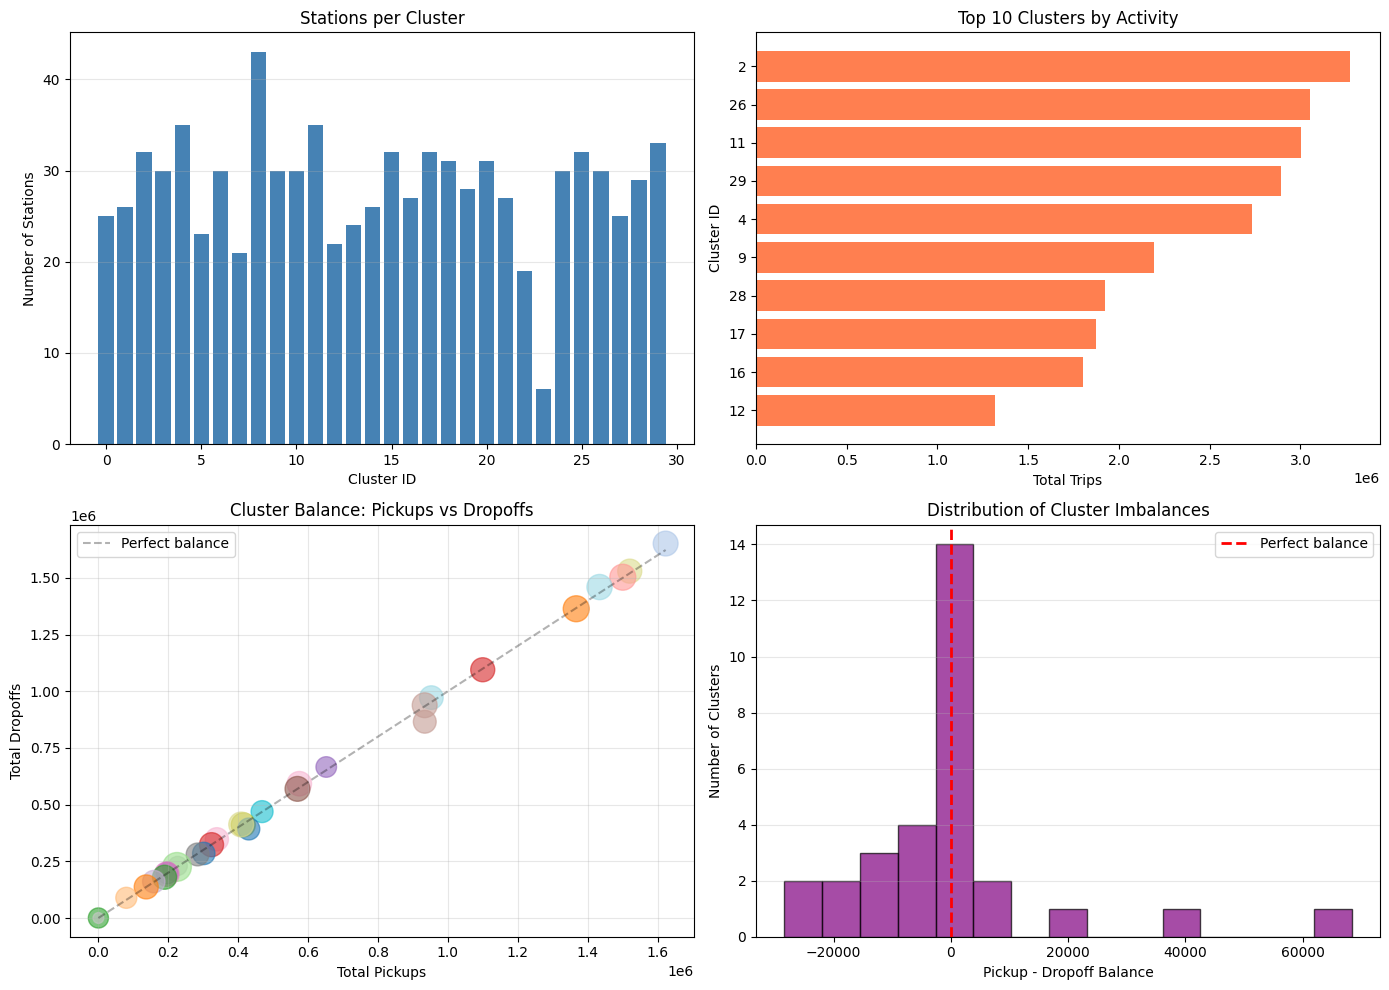

Clustering Summary:
   • Total clusters: 30
   • Avg stations per cluster: 28.1
   • Most balanced cluster: 23 (balance: +25)
   • Most imbalanced cluster: 16 (balance: +68,370)


In [174]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Cluster size distribution
axes[0, 0].bar(cluster_stats.index, cluster_stats["num_stations"], color="steelblue")
axes[0, 0].set_xlabel("Cluster ID")
axes[0, 0].set_ylabel("Number of Stations")
axes[0, 0].set_title("Stations per Cluster")
axes[0, 0].grid(axis="y", alpha=0.3)

# 2. Total trips per cluster
top_10 = cluster_stats.nlargest(10, "total_trips")
axes[0, 1].barh(top_10.index.astype(str), top_10["total_trips"], color="coral")
axes[0, 1].set_xlabel("Total Trips")
axes[0, 1].set_ylabel("Cluster ID")
axes[0, 1].set_title("Top 10 Clusters by Activity")
axes[0, 1].invert_yaxis()

# 3. Pickup vs Dropoff balance
axes[1, 0].scatter(
    cluster_stats["pickup_count"],
    cluster_stats["dropoff_count"],
    s=cluster_stats["num_stations"] * 10,
    alpha=0.6,
    c=cluster_stats.index,
    cmap="tab20",
)
axes[1, 0].plot(
    [0, cluster_stats["pickup_count"].max()],
    [0, cluster_stats["pickup_count"].max()],
    "k--",
    alpha=0.3,
    label="Perfect balance",
)
axes[1, 0].set_xlabel("Total Pickups")
axes[1, 0].set_ylabel("Total Dropoffs")
axes[1, 0].set_title("Cluster Balance: Pickups vs Dropoffs")
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Imbalance distribution
axes[1, 1].hist(
    cluster_stats["balance"], bins=15, color="purple", alpha=0.7, edgecolor="black"
)
axes[1, 1].axvline(0, color="red", linestyle="--", linewidth=2, label="Perfect balance")
axes[1, 1].set_xlabel("Pickup - Dropoff Balance")
axes[1, 1].set_ylabel("Number of Clusters")
axes[1, 1].set_title("Distribution of Cluster Imbalances")
axes[1, 1].legend()
axes[1, 1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

print("Clustering Summary:")
print(f"   • Total clusters: {n_clusters}")
print(f"   • Avg stations per cluster: {cluster_stats['num_stations'].mean():.1f}")
print(
    f"   • Most balanced cluster: {cluster_stats['balance'].abs().idxmin()} (balance: {cluster_stats['balance'].abs().min():+,.0f})"
)
print(
    f"   • Most imbalanced cluster: {cluster_stats['balance'].abs().idxmax()} (balance: {cluster_stats.loc[cluster_stats['balance'].abs().idxmax(), 'balance']:+,.0f})"
)

# Feature Engineering